Please upload a .nii or .nii.gz file:


Saving CT8_4.nii.gz to CT8_4.nii.gz


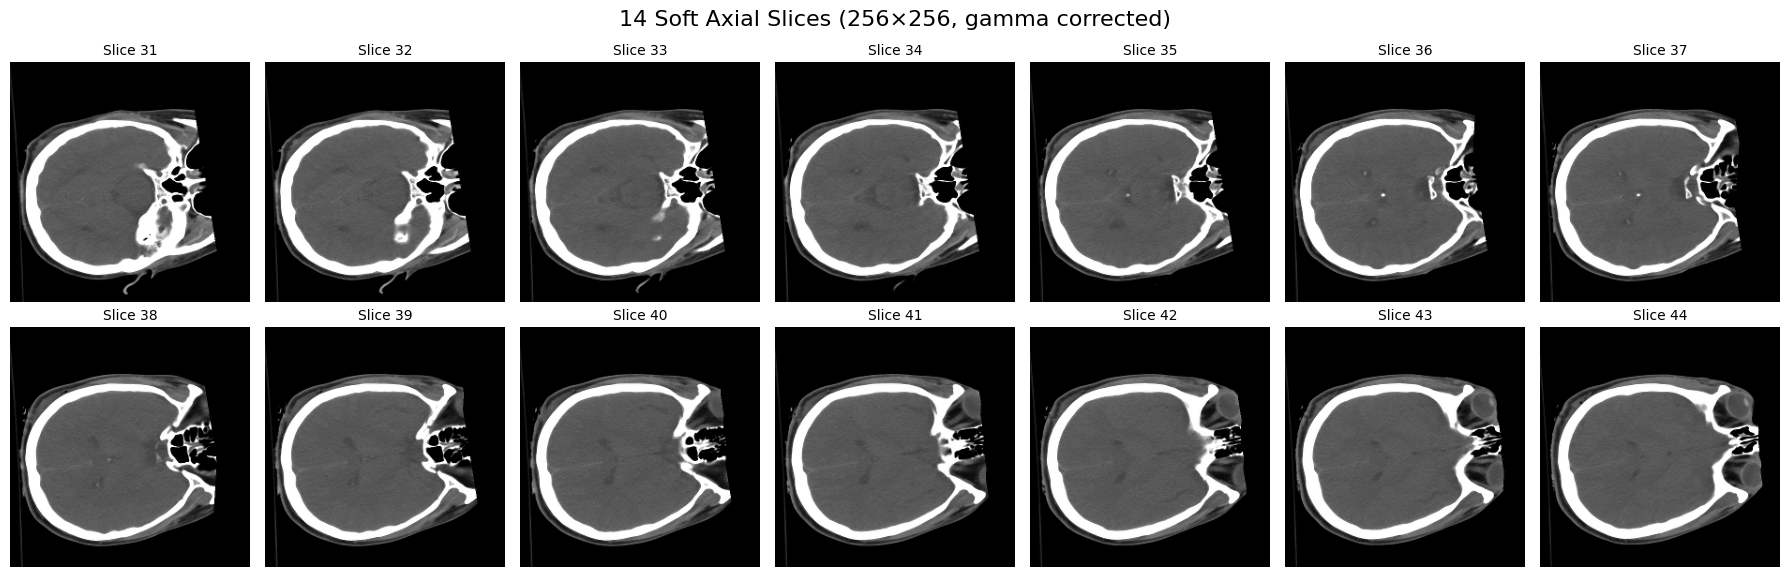

In [ ]:
import os
import numpy as np
import nibabel as nib
import cv2
import matplotlib.pyplot as plt
from google.colab import files

# === Upload and sanitize filename ===
print("Please upload a .nii or .nii.gz file:")
uploaded = files.upload()
original_name = list(uploaded.keys())[0]
clean_name = "uploaded_image.nii.gz"
os.rename(original_name, clean_name)

# === Load NIfTI image ===
nii = nib.load(clean_name)
volume = nii.get_fdata()

# === Extract 14 middle axial slices ===
z_dim = volume.shape[2]
center = z_dim // 2
start = max(center - 7, 0)
end = min(center + 7, z_dim)
slices = []

# === Apply soft tissue-style windowing & gamma correction ===
def apply_soft_window(image, wl=40, ww=400, gamma=1.5):
    wl_min = wl - ww / 2
    wl_max = wl + ww / 2
    windowed = np.clip(image, wl_min, wl_max)
    norm = (windowed - wl_min) / (wl_max - wl_min)
    norm = np.clip(norm, 0, 1)
    norm = norm ** gamma  # gamma compression = soft look
    return (norm * 255).astype(np.uint8)

# === Resize while preserving aspect, pad to 256×256 ===
def resize_and_pad(image, size=256):
    h, w = image.shape
    scale = min(size / h, size / w)
    resized = cv2.resize(image, (int(w * scale), int(h * scale)), interpolation=cv2.INTER_LANCZOS4)
    padded = np.zeros((size, size), dtype=np.uint8)
    y_offset = (size - resized.shape[0]) // 2
    x_offset = (size - resized.shape[1]) // 2
    padded[y_offset:y_offset + resized.shape[0], x_offset:x_offset + resized.shape[1]] = resized
    return padded

# === Process each slice ===
for i in range(start, end):
    slice_img = volume[:, :, i]
    soft_img = apply_soft_window(slice_img)
    padded = resize_and_pad(soft_img)
    slices.append(padded)

# === Display in grid ===
plt.figure(figsize=(18, 6))
for idx, img in enumerate(slices):
    plt.subplot(2, 7, idx + 1)
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.title(f"Slice {start + idx}", fontsize=10)
    plt.axis('off')
plt.suptitle("14 Soft Axial Slices (256×256, gamma corrected)", fontsize=16)
plt.tight_layout()
plt.show()
